# SupplyzPro: Technical Assessment

# 1. Assessment Introduction

## Goal




In this assessment, your objective is to explore and forecast the industrial production of electric and gas utilities in the United States from 1939 to 2019. The data, sourced from the Federal Reserve Economic Data (FRED) database, provides monthly production output, allowing us to analyze long-term trends, seasonal patterns, and forecast future values.

Data Source: Industrial Production: Electric and Gas Utilities
Link: https://fred.stlouisfed.org/series/IPG2211A2N




## Recommendations


As you proceed, keep in mind the following evaluation criteria:

- Code Modularity: Structure your code into clear, reusable functions where possible.
- Code Quality: Ensure readability, use meaningful variable names, and document your steps.
- Explain Your Reasoning: Include comments and markdown explanations for each decision made, describing your approach and any assumptions.

**IMPORTANT: We highly recommend structuring the code in separate scripts instead of using a single notebook for everything.!**


# Code

## 1. Data Exploration


In this section we recommend you to:
- Visualizing the data to get an overview of its patterns and structure.
- Preparing the data as needed to ensure it’s ready for analysis.
- Identifying any trends or recurring patterns that may influence the approach to modeling.


In [58]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error



In [59]:
data = pd.read_csv("/content/IPG2211A2N.csv", parse_dates=["observation_date"], index_col="observation_date")
data

,IPG2211A2N
observation_date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608
...,...
2024-06-01,109.1424
2024-07-01,120.0882
2024-08-01,118.4131


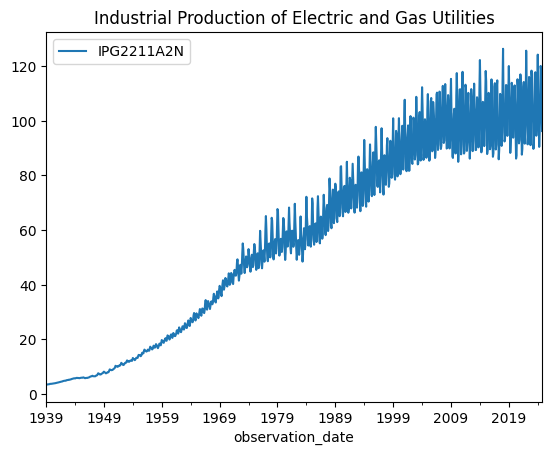

In [60]:
data.plot(title="Industrial Production of Electric and Gas Utilities")
plt.show()

<Axes: ylabel='observation_date'>

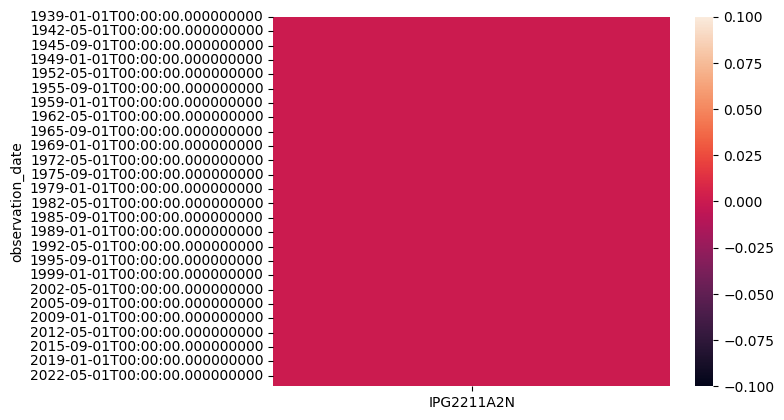

In [61]:
sns.heatmap(data.isnull())

In [62]:
result = adfuller(data['IPG2211A2N'])
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")

ADF Statistic: -0.7144157341270216, p-value: 0.8429801190131684


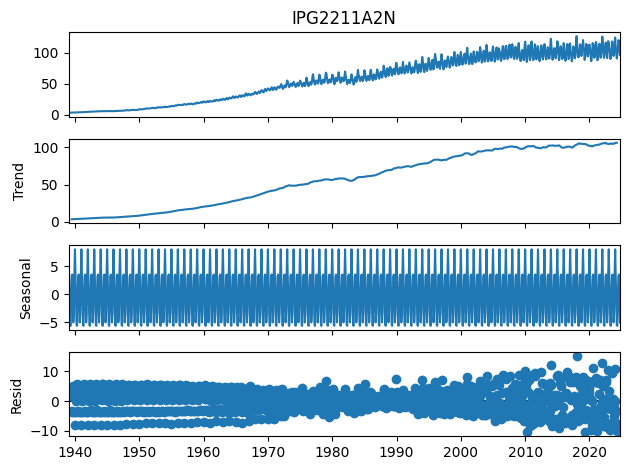

In [63]:
decomposition = seasonal_decompose(data['IPG2211A2N'], model='additive')
decomposition.plot()
plt.show()

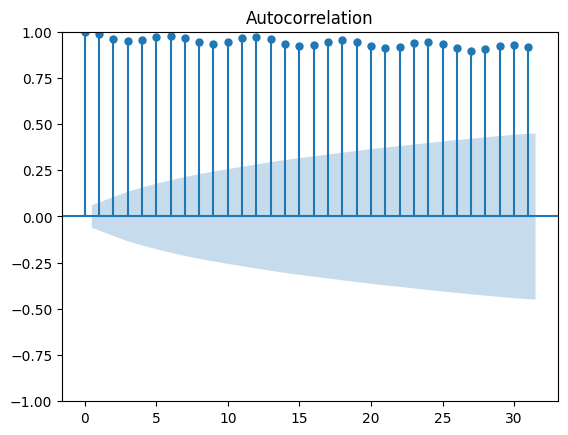

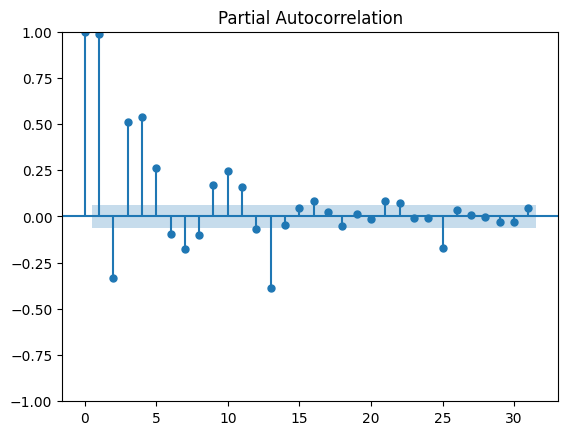

In [64]:
plot_acf(data['IPG2211A2N'])
plot_pacf(data['IPG2211A2N'])
plt.show()

## 2. Model Building

In this section, focus on:

- Selecting model parameters based on initial observations.
- Building appropriate models that align with the data characteristics.
- Refining the model through adjustments to enhance its ability to capture essential patterns.


In [65]:
warnings.filterwarnings("ignore")
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None

for param in pdq:
    try:
        model = ARIMA(data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
    except:
        continue

print(f"Best order: {best_order}, AIC: {best_aic}")

Best order: (2, 1, 3), AIC: 4919.294200608153


In [66]:
model = ARIMA(data, order=(2, 1, 3))
fitted_arima = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                 1030
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2453.647
Date:                Sun, 15 Dec 2024   AIC                           4919.294
Time:                        16:31:30   BIC                           4948.912
Sample:                    01-01-1939   HQIC                          4930.535
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1541.229      0.000       0.998       1.001
ar.L2         -0.9999      0.000  -6951.941      0.000      -1.000      -1.000
ma.L1         -1.2278      0.019    -63.540      0.0

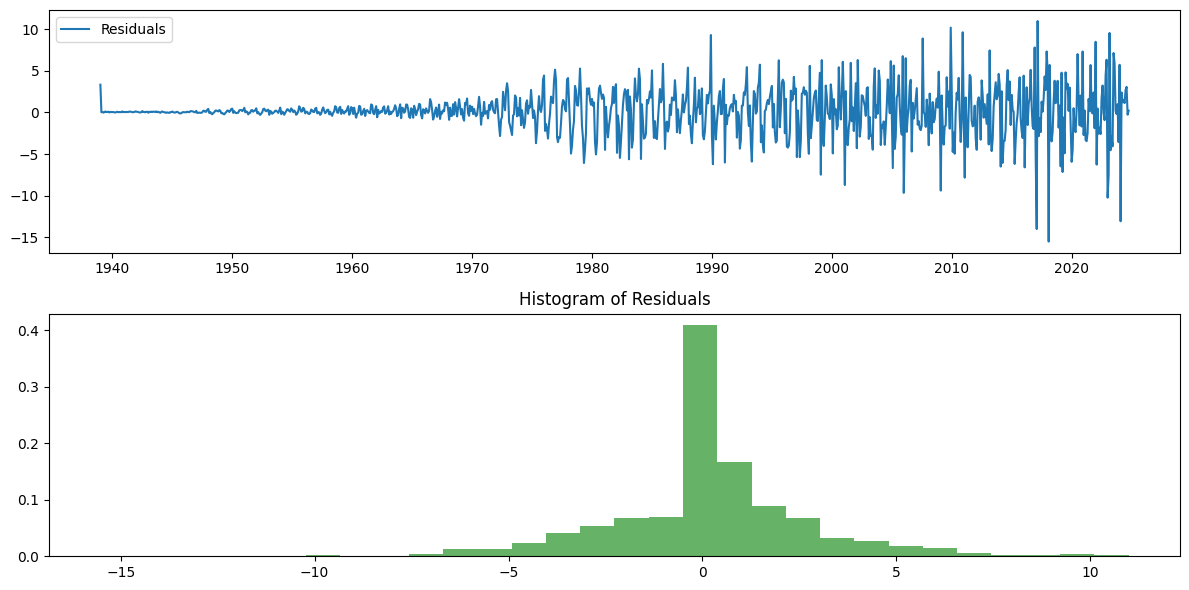

In [67]:
residuals = fitted_arima.resid
# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals, label='Residuals')
plt.legend()
plt.subplot(212)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

In [68]:
# Model Building
initial_order = (2, 1, 3)
seasonal_order = (2, 1, 3, 12)
model = SARIMAX(data, order=initial_order, seasonal_order=seasonal_order)
fitted_sarima = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                 1030
Model:                 ARIMA(3, 3, 3)   Log Likelihood               -2702.496
Date:                Sun, 15 Dec 2024   AIC                           5418.992
Time:                        16:32:29   BIC                           5453.533
Sample:                    01-01-1939   HQIC                          5432.103
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4681      0.019     24.125      0.000       0.430       0.506
ar.L2         -0.4694      0.019    -24.467      0.000      -0.507      -0.432
ar.L3         -0.5263      0.019    -27.486      0.0

In [74]:
# Create lagged features
def create_lag_features(data, lags=12):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df['IPG2211A2N'].shift(lag)
    return df.dropna()

# Load your data (assuming 'data' is a DataFrame with 'target' and a time index)
# data = pd.read_csv('your_data.csv', parse_dates=True, index_col='date')

# Create lagged features
lagged_data = create_lag_features(data)
X = lagged_data.drop(columns='IPG2211A2N')
y = lagged_data['IPG2211A2N']

# Split into train and test sets
train_size = len(data) - 36  # Last 24 months for testing
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=200,learning_rate=0.05,max_depth=6,min_child_weight=3,
                         subsample=0.8,colsample_bytree=0.8,gamma=0,reg_alpha=0.1,reg_lambda=1,random_state=42,verbosity=1)
model.fit(X_train, y_train)
# Forecast future values
Xgboost_forecast = model.predict(X_test)

## 3. Model Evaluation

In this section, aim to:

- Evaluate the model’s accuracy by applying relevant metrics.
- Examine the model’s results to confirm it captures key aspects of the data.
- Assess the model’s predictive capability, noting any potential limitations.


In [71]:
actual_values = data[-36:]
# Predictions from the model
predicted_values = fitted_sarima.get_forecast(steps=36).predicted_mean

# Calculate MAE, MSE, RMSE, and MAPE of SARIMA
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_values, predicted_values)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


Mean Absolute Error (MAE): 2.8265
Mean Squared Error (MSE): 13.0848
Root Mean Squared Error (RMSE): 3.6173
Mean Absolute Percentage Error (MAPE): 0.0269


In [75]:

# Calculate MAE, MSE, RMSE, and MAPE of Xgboost model
mae = mean_absolute_error(y_test, Xgboost_forecast)
mse = mean_squared_error(y_test, Xgboost_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, Xgboost_forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


Mean Absolute Error (MAE): 3.7182
Mean Squared Error (MSE): 20.6187
Root Mean Squared Error (RMSE): 4.5408
Mean Absolute Percentage Error (MAPE): 0.0344


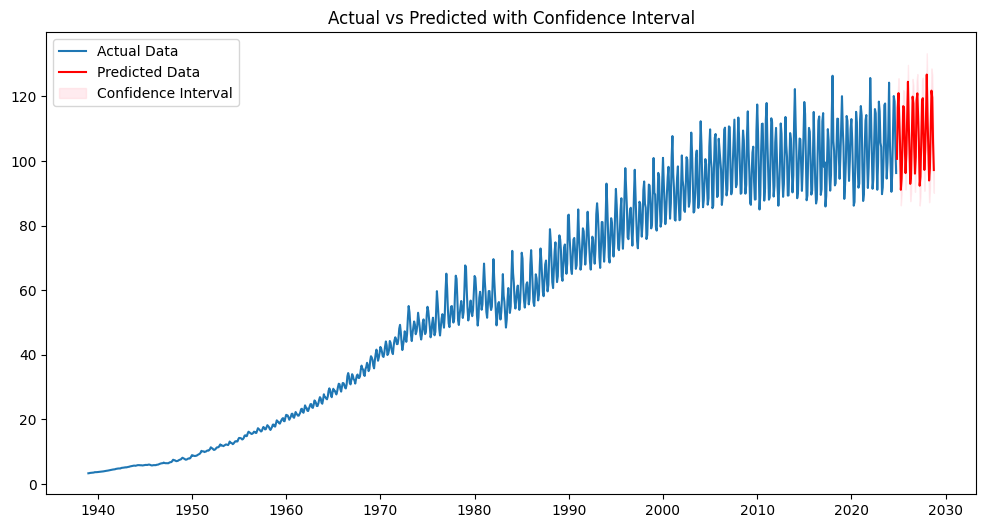

In [76]:
# Visualize both actual values and forecasted values for comparison
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(forecast.predicted_mean, label='Predicted Data', color='red')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title('Actual vs Predicted with Confidence Interval')
plt.show()
